In [78]:
# imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import copy;

import torch
import torch.nn as nn
import torch.optim as optim
   
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder

In [79]:
device = "cpu"
if (torch.cuda.is_available()):
    # if GPU available, use cuda
    device = "cuda"

In [80]:
dataset = pd.read_csv("Dry_Bean_Dataset.csv", header=0)

rows=len(dataset.axes[0])
cols=len(dataset.axes[1])

print("Number of Rows: "+str(rows))
print("Number of Columns: "+str(cols))
print(dataset.head())

Number of Rows: 13611
Number of Columns: 17
    Area  Perimeter  MajorAxisLength  MinorAxisLength  AspectRation   
0  28395    610.291       208.178117       173.888747      1.197191  \
1  28734    638.018       200.524796       182.734419      1.097356   
2  29380    624.110       212.826130       175.931143      1.209713   
3  30008    645.884       210.557999       182.516516      1.153638   
4  30140    620.134       201.847882       190.279279      1.060798   

   Eccentricity  ConvexArea  EquivDiameter    Extent  Solidity  roundness   
0      0.549812       28715     190.141097  0.763923  0.988856   0.958027  \
1      0.411785       29172     191.272750  0.783968  0.984986   0.887034   
2      0.562727       29690     193.410904  0.778113  0.989559   0.947849   
3      0.498616       30724     195.467062  0.782681  0.976696   0.903936   
4      0.333680       30417     195.896503  0.773098  0.990893   0.984877   

   Compactness  ShapeFactor1  ShapeFactor2  ShapeFactor3  ShapeFac

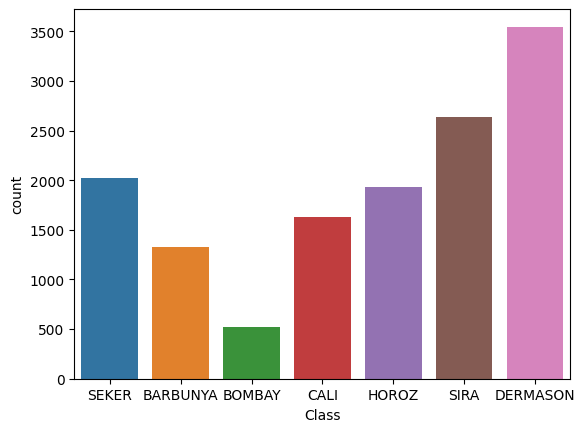

In [81]:
# all occurrences of classes
sns.countplot(x = 'Class', data=dataset)
plt.show()

In [82]:
X = dataset.iloc[:, 0:(cols-1)]  # features
y = dataset.iloc[:, (cols-1):]  # classes

# encode classes names to one hot vectors
encode = OneHotEncoder(handle_unknown='ignore', sparse_output=False).fit(y)

print(encode.categories)

y = encode.transform(y)

print("One-hot-vectors")
print(np.unique(y, axis=0))

classes = len(np.unique(y, axis=0)) # number of classe

auto
One-hot-vectors
[[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [83]:
# convert X and y to pytorch tensors
X = torch.tensor(X.values, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True)  # split data - train 80% / test 20%

In [84]:
# model class
class Network(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(cols-1, 8)     # cols-1 = number of features (input)
        self.act1 = nn.ReLU()
        self.hidden2 = nn.Linear(8, 16)
        self.act2 = nn.ReLU()
        self.hidden3 = nn.Linear(16, 24)
        self.act3 = nn.ReLU()
        self.hidden4 = nn.Linear(24, 16)
        self.act4 = nn.ReLU()
        self.output = nn.Linear(16, classes)    # classes = number of expected outputs
        
    def forward(self, x):
        x = self.act1(self.hidden1(x))
        x = self.act2(self.hidden2(x))
        x = self.act3(self.hidden3(x))
        x = self.act4(self.hidden4(x))
        x = self.output(x)
        return x
    

In [85]:
model = Network()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# training parameters
n_epochs = 120
batch_size_step = 43
num_of_batches = len(X_train) // batch_size_step     # number of batches in epoch

In [86]:
# variables and lists for graphs plotting and best trained model saving
best_acc = 0
best_weights = None
train_losses = []
train_accs = []
test_losses = []
test_accs = []

In [87]:
# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    for i in range(0, num_of_batches):
        # go through number of batches in one epoch in batch_size step
        start = i * batch_size_step
        X_batch = X_train[start:start+batch_size_step]
        y_batch = y_train[start:start+batch_size_step]

        # forward pass
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)

        # backward pass
        optimizer.zero_grad()
        loss.backward()

        # update weights
        optimizer.step()

        # compute and store metrics
        acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
        epoch_loss.append(float(loss))
        epoch_acc.append(float(acc))

    if epoch % 20 == 0 or epoch == 119:
        print(f"Epoch {epoch} training: Loss={loss:.2f}, Accuracy={acc*100:.1f}%")

    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    loss = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    loss = float(loss)
    acc = float(acc)

    train_losses.append(np.mean(epoch_loss))
    train_accs.append(np.mean(epoch_acc))
    test_losses.append(loss)
    test_accs.append(acc)

    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())

    if epoch % 20 == 0 or epoch == 119:
        print(f"Epoch {epoch} validation: Loss={loss:.2f}, Accuracy={acc*100:.1f}%")

tensor(0.0698)
tensor(0.1163)
tensor(0.0930)
tensor(0.0233)
tensor(0.)
tensor(0.0465)
tensor(0.0930)
tensor(0.1163)
tensor(0.1860)
tensor(0.)
tensor(0.)
tensor(0.0233)
tensor(0.0698)
tensor(0.0698)
tensor(0.0465)
tensor(0.0233)
tensor(0.0930)
tensor(0.1628)
tensor(0.0465)
tensor(0.1628)
tensor(0.2326)
tensor(0.1628)
tensor(0.0698)
tensor(0.1163)
tensor(0.1163)
tensor(0.1628)
tensor(0.1395)
tensor(0.1163)
tensor(0.0698)
tensor(0.1860)
tensor(0.2093)
tensor(0.3023)
tensor(0.2326)
tensor(0.0698)
tensor(0.1395)
tensor(0.0930)
tensor(0.0698)
tensor(0.0465)
tensor(0.1163)
tensor(0.2558)
tensor(0.3488)
tensor(0.1395)
tensor(0.0465)
tensor(0.0465)
tensor(0.2093)
tensor(0.0930)
tensor(0.1395)
tensor(0.1163)
tensor(0.3488)
tensor(0.1395)
tensor(0.1628)
tensor(0.3023)
tensor(0.2558)
tensor(0.0930)
tensor(0.2093)
tensor(0.0698)
tensor(0.2326)
tensor(0.0930)
tensor(0.0233)
tensor(0.0698)
tensor(0.0233)
tensor(0.0930)
tensor(0.0698)
tensor(0.2326)
tensor(0.1395)
tensor(0.0930)
tensor(0.3488)
tensor(

KeyboardInterrupt: 

In [ ]:
def final_test(model):
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)

    print(f"Final test of best trained model: Loss={ce:.2f}, Accuracy={acc*100:.1f}%")

    return y_pred

In [ ]:
model.load_state_dict(best_weights)

y_pred = final_test(model)

y_pred = torch.argmax(y_pred, dim=1)
y_test = torch.argmax(y_test, dim=1)

Final test of best trained model: Loss=0.37, Accuracy=85.8%


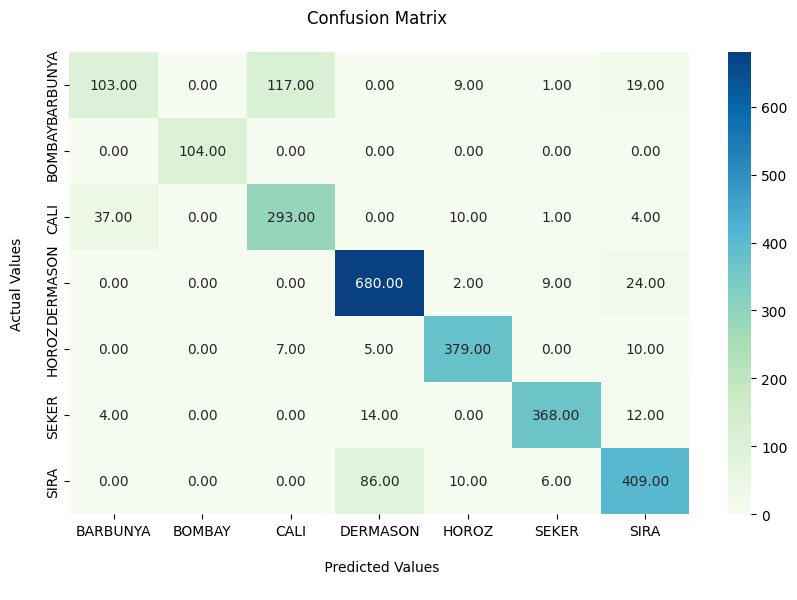

In [ ]:
# confusion matrix

plt.figure(figsize=(10,6))
fx=sns.heatmap(confusion_matrix(y_test,y_pred), annot=True, fmt=".2f",cmap="GnBu")
fx.set_title('Confusion Matrix \n');
fx.set_xlabel('\n Predicted Values\n')
fx.set_ylabel('Actual Values\n');
fx.xaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])
fx.yaxis.set_ticklabels(['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA'])
plt.show()

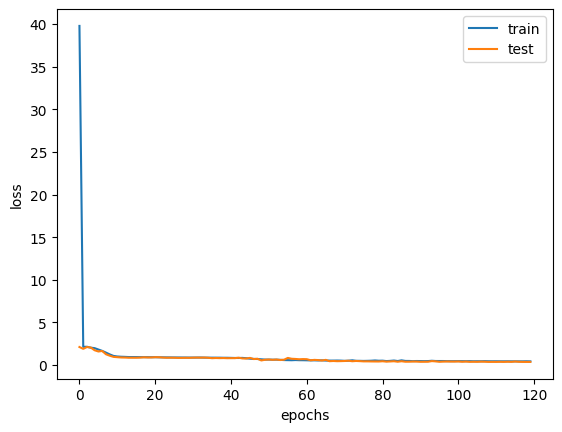

In [ ]:
# losses plot
plt.plot(train_losses, label="train")
plt.plot(test_losses, label="test")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

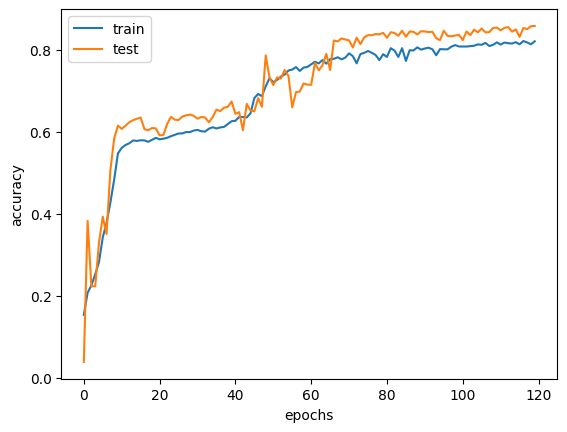

In [ ]:
# accuracy plot

plt.plot(train_accs, label="train")
plt.plot(test_accs, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()